In [1484]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import pandas_profiling
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [1486]:
data = pd.read_csv('data.csv', delimiter=';')
data.head()


city_load country_load     city_unload country_unload  Cargo_volume  \
0    Москва       Россия       Челябинск         Россия           0.0   
1     Миасс       Россия            Омск         Россия           0.0   
2  Смоленск       Россия         Красный         Россия           0.0   
3    Казань       Россия  Индустриальный         Россия          80.0   
4     Можга       Россия    Екатеринбург         Россия           5.9   

   Cargo_weight  ADR  Qu_Cars  Dist  PalletCount          cargo_name  \
0          20.0    0        2  1794            0      Consumer goods   
1           5.0    0        1  1046            5                Sand   
2          20.0    0        1    52            0               Sugar   
3          20.0    0        1  1363            0  Building materials   
4           0.7    0        1   775            0  Means of transport   

   PrepayPercent  money_rub        Date  
0              0    85000.0  2023-02-18  
1              0    30000.0  2023-04-21  
2              0     7000.0  2023-02-05  
3             50    74000.0  2023-05-17  
4              0     9000.0  2023-03-15

In [1487]:
print(data.info())
print(data.shape)
print(data.describe())
print(data.head())
print(data.Date.min(), data.Date.max())
# Средний объем груза составляет 38 тонн, медианное значение 20 тонн, что указывает на существенный разброс данных,
# так как среднее значение значительно выше медианы. Большинство из значений обьема груза, веса груза
# и уровня опасности груза имеют низкие значения - меньше 50% от максимальных значений. 
# Большинство заказов состоят из одного автомобиля (медианное значение - 1), но есть выброс, так как 
# максимальное значение равно 99. Значения в столбце ADR распределены преимущественно вокруг нуля.
# В датасете представлены данные за 3 месяца перевозок


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114456 entries, 0 to 114455
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   city_load       114282 non-null  object 
 1   country_load    114456 non-null  object 
 2   city_unload     114279 non-null  object 
 3   country_unload  114456 non-null  object 
 4   Cargo_volume    114456 non-null  float64
 5   Cargo_weight    114456 non-null  float64
 6   ADR             114456 non-null  int64  
 7   Qu_Cars         114456 non-null  int64  
 8   Dist            114456 non-null  int64  
 9   PalletCount     114456 non-null  int64  
 10  cargo_name      114456 non-null  object 
 11  PrepayPercent   114456 non-null  int64  
 12  money_rub       114456 non-null  float64
 13  Date            114456 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 12.2+ MB
None
(114456, 14)
        Cargo_volume   Cargo_weight            ADR        Qu_Cars  \
cou

In [1488]:
data.isnull().sum()

city_load         174
country_load        0
city_unload       177
country_unload      0
Cargo_volume        0
Cargo_weight        0
ADR                 0
Qu_Cars             0
Dist                0
PalletCount         0
cargo_name          0
PrepayPercent       0
money_rub           0
Date                0
dtype: int64

In [1489]:
data = data.dropna()
data.drop_duplicates(inplace=True)

In [1490]:
#Если есть пробелы в начале и конце данных
for col in data.select_dtypes(include=[object]).columns:
    data[col] = data[col].str.strip()

In [1491]:
#Преобразуем к нижнему регистру
keys = ['city_load', 'country_load', 'city_unload', 'country_unload', 'cargo_name']
for key in keys:
     data[key] = data[key].str.lower()

In [1492]:
#Те значения, которые встречаются реже всего могут содержать ошибки в названии, которые нужно исправить
print(data['city_load'].value_counts().tail(10))
print(data['country_load'].value_counts().tail(10))
print(data['city_unload'].value_counts().tail(10))
print(data['country_unload'].value_counts().tail(10))
#Кажется их нет

прикубанский                    3
джабык                          3
барыбино (домодедово го) дер    3
лобаново (истра го)             3
белый                           3
корабсельки                     3
серебряные пруды                3
каргасок                        3
медведево                       2
новопокровская                  2
Name: city_load, dtype: int64
узбекистан     12
эстония         9
италия          6
бельгия         6
азербайджан     6
молдова         6
грузия          3
литва           3
франция         3
кыргызстан      3
Name: country_load, dtype: int64
талашкино                      3
трубный                        3
мулино пос                     3
большое нагаткино              3
сокрутовка                     3
тюлячи                         3
мшинская                       3
беслан аэропорт владикавказ    3
новогеоргиевка                 2
соколово (щёлково го)          2
Name: city_unload, dtype: int64
оаэ             9
армения         6
грузия          6
ю

In [1493]:
def delete_outliers(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    data = data[(data[col] >= q1 - 1.5*iqr) & (data[col] <= q3 + 1.5*iqr)]
    return data

In [1494]:
#Удалим выбросы, используя межквартильный размах
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
print(len(data))
for col in numeric_cols:
    data = delete_outliers(data, col)
print(len(data))
data = data[data['Cargo_volume'] != 0]
data = data[data['Cargo_weight'] != 0]
print(len(data))

113032
73506
51357


In [1495]:
report = pandas_profiling.ProfileReport(data)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

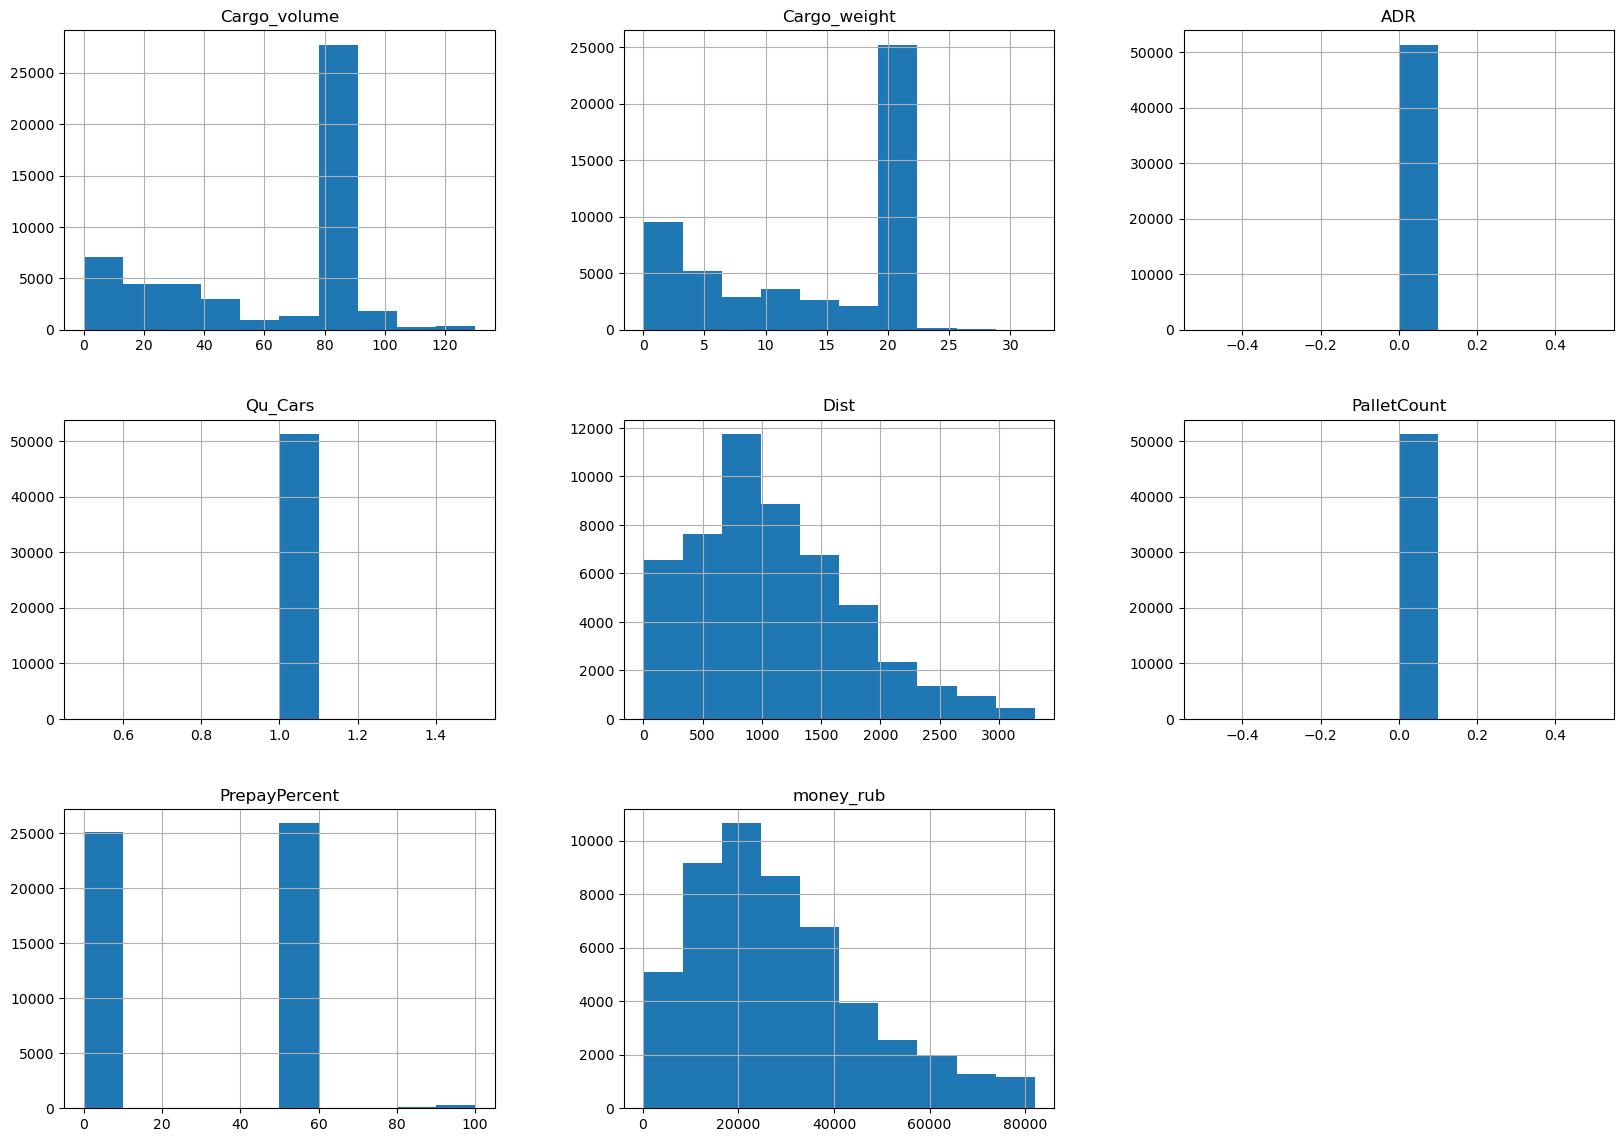

In [1496]:
data.hist(figsize=(20,14))
plt.show()


/Users/ekaterinaakulova/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


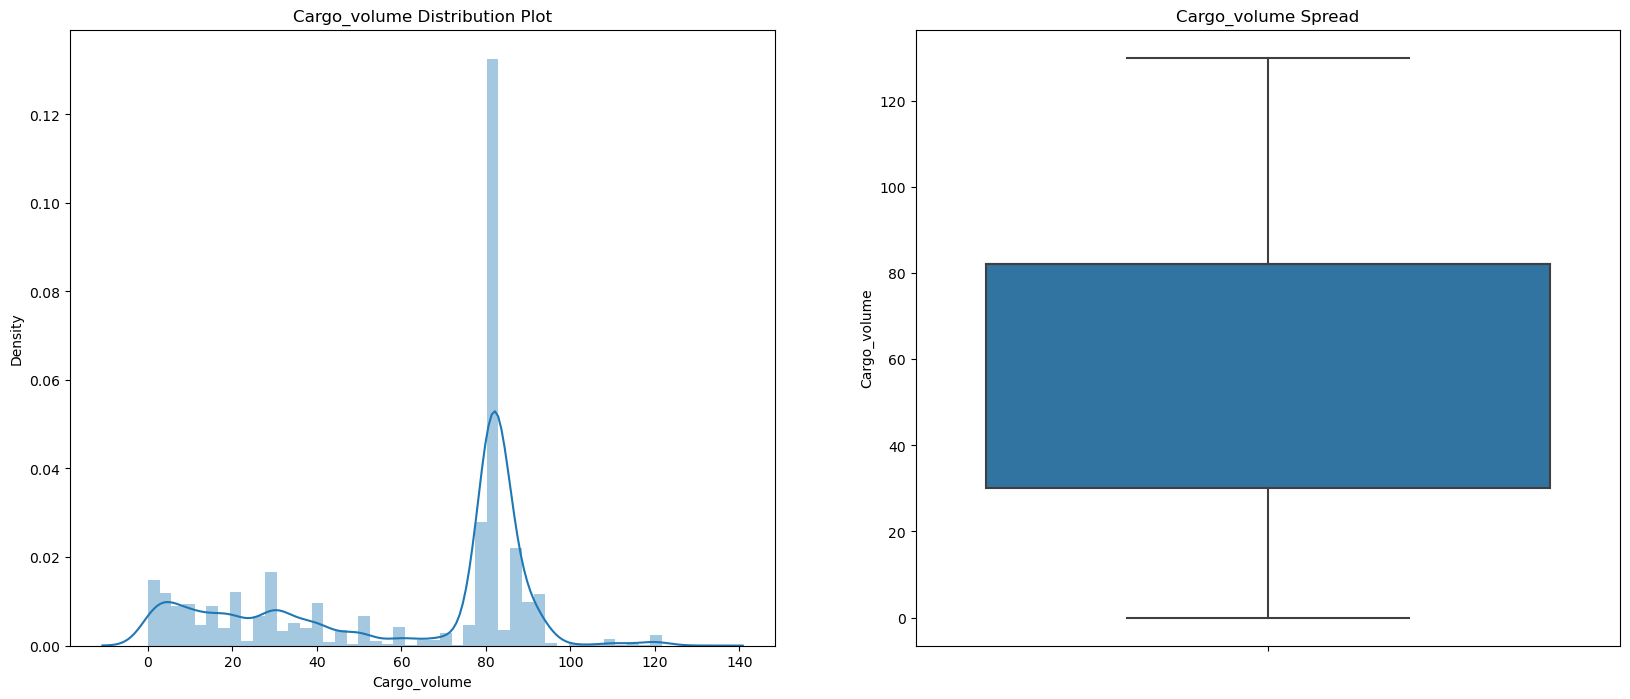

In [1497]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Cargo_volume Distribution Plot')
sns.distplot(data.Cargo_volume)


plt.subplot(1,2,2)
plt.title('Cargo_volume Spread')
sns.boxplot(y=data.Cargo_volume)

plt.show()

/Users/ekaterinaakulova/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


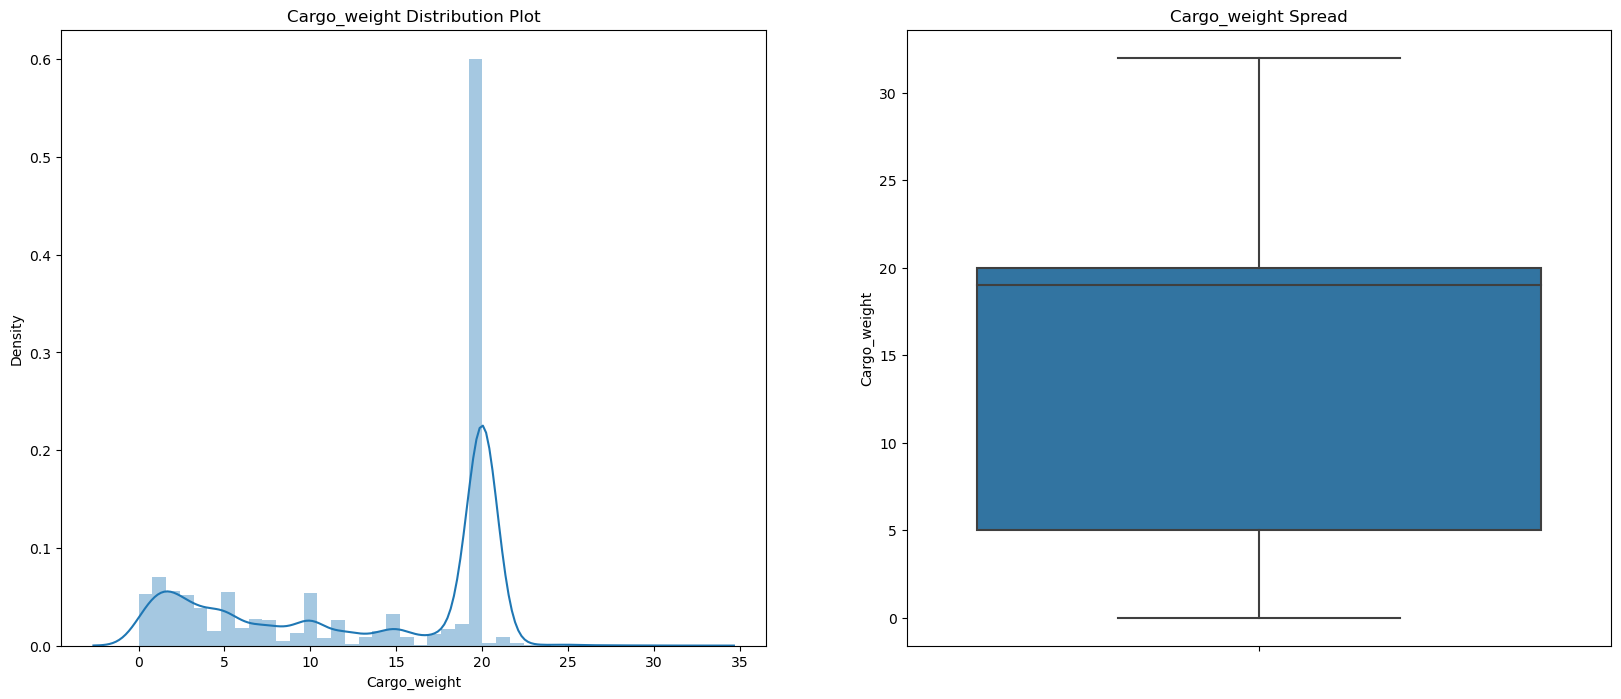

In [1498]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Cargo_weight Distribution Plot')
sns.distplot(data.Cargo_weight)


plt.subplot(1,2,2)
plt.title('Cargo_weight Spread')
sns.boxplot(y=data.Cargo_weight)

plt.show()

/Users/ekaterinaakulova/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


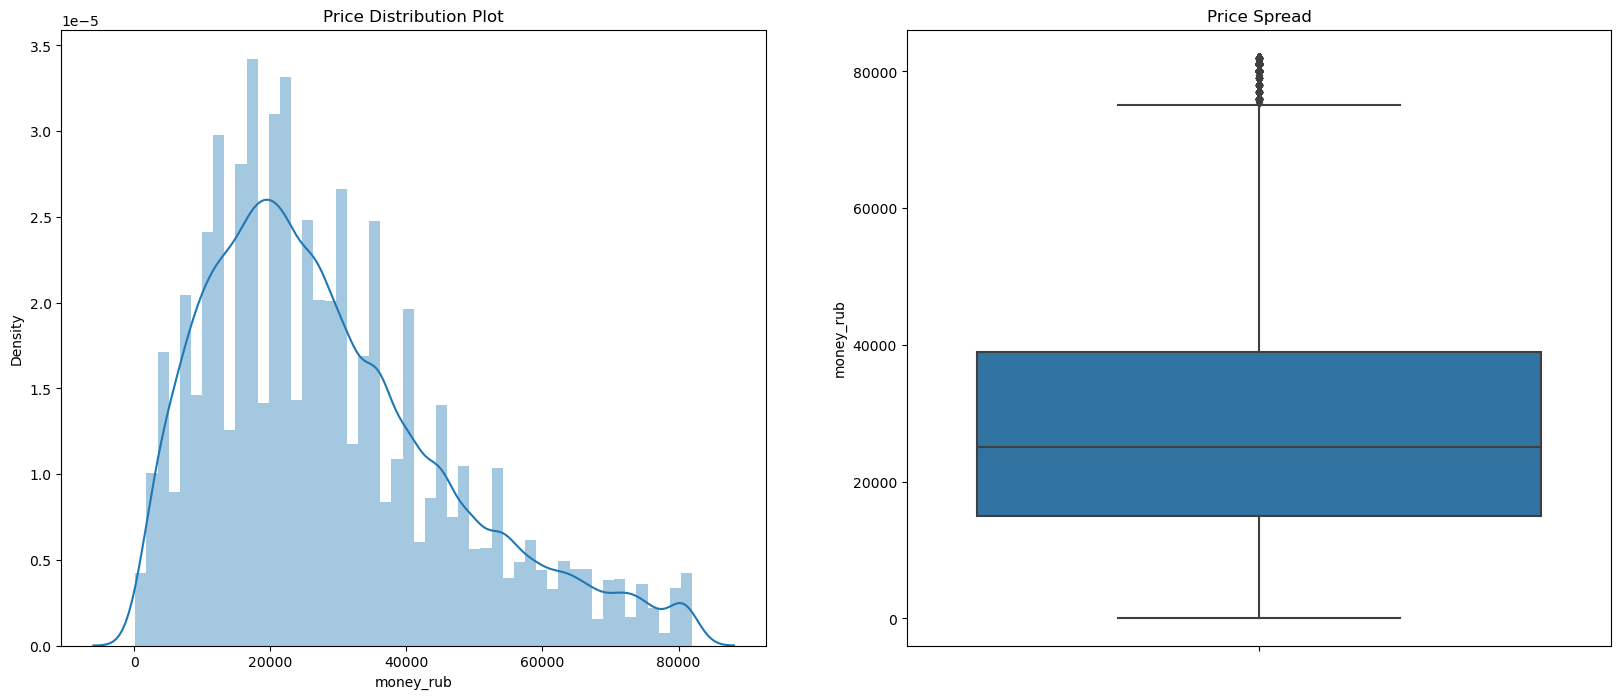

count    51357.000000
mean     28670.708258
std      17936.236262
min        120.000000
25%      15000.000000
50%      25000.000000
75%      39000.000000
85%      48000.000000
90%      55000.000000
100%     82000.000000
max      82000.000000
Name: money_rub, dtype: float64


In [1499]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Price Distribution Plot')
sns.distplot(data.money_rub)


plt.subplot(1,2,2)
plt.title('Price Spread')
sns.boxplot(y=data.money_rub)

plt.show()
print(data.money_rub.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))
#распределение данных скошено вправо
#большой разброс значений в столбце
#довольно большое количество значений находятся в интервале от 15000 до 39000 (межквартильный интервал)


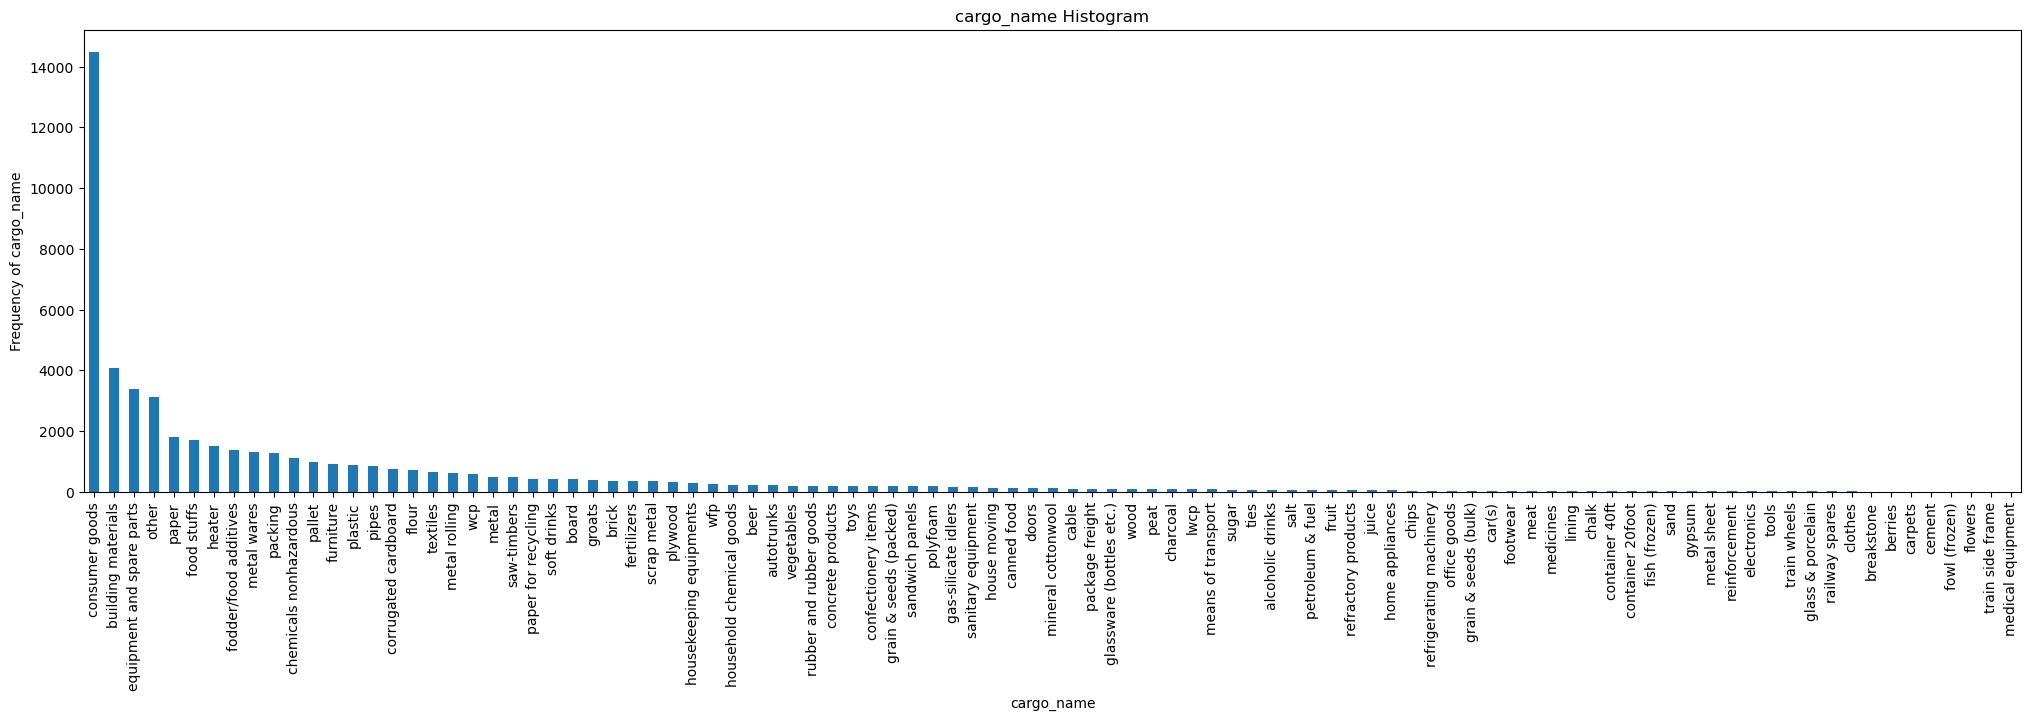

In [1500]:
plt.figure(figsize=(25, 6))
plt1 = data.cargo_name.value_counts().plot(kind='bar')
plt.title('cargo_name Histogram')
plt1.set(xlabel = 'cargo_name', ylabel='Frequency of cargo_name')
plt.show()

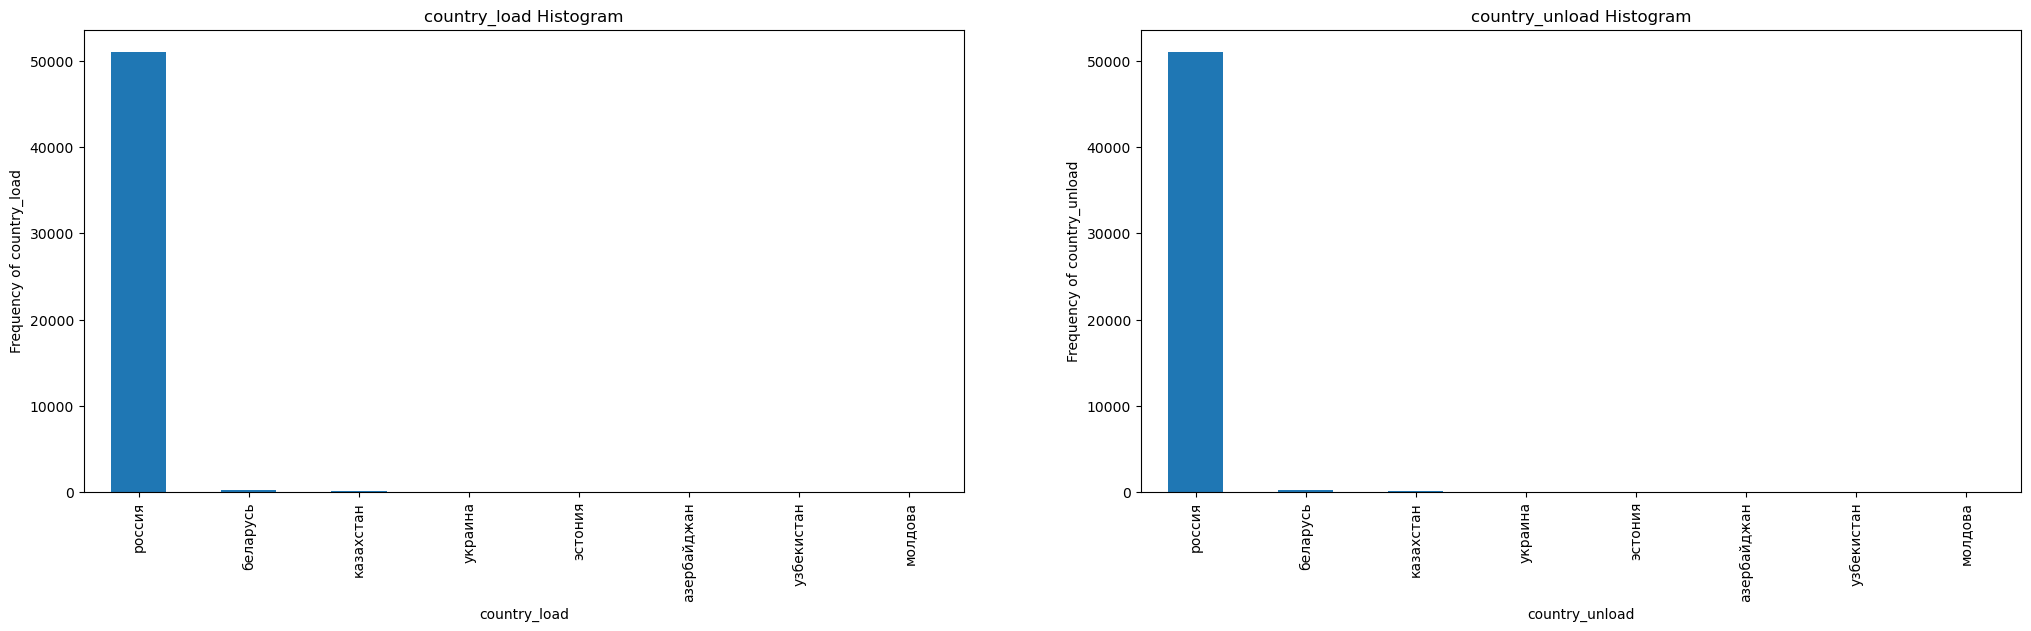

In [1501]:
plt.figure(figsize=(25, 6))
plt.subplot(1,2,1)
plt1 = data.country_load.value_counts().plot(kind='bar')
plt.title('country_load Histogram')
plt1.set(xlabel = 'country_load', ylabel='Frequency of country_load')
plt.subplot(1,2,2)
plt2 = data.country_load.value_counts().plot(kind='bar')
plt.title('country_unload Histogram')
plt2.set(xlabel = 'country_unload', ylabel='Frequency of country_unload')
plt.show()
#Практически все погрузки и разгрузки осуществлялись в России

In [1502]:
def scatter(x,fig):
    plt.subplot(5,2,fig)
    plt.scatter(data[x],data['money_rub'])
    plt.title(x+' vs Price')
    plt.ylabel('Price')
    plt.xlabel(x)

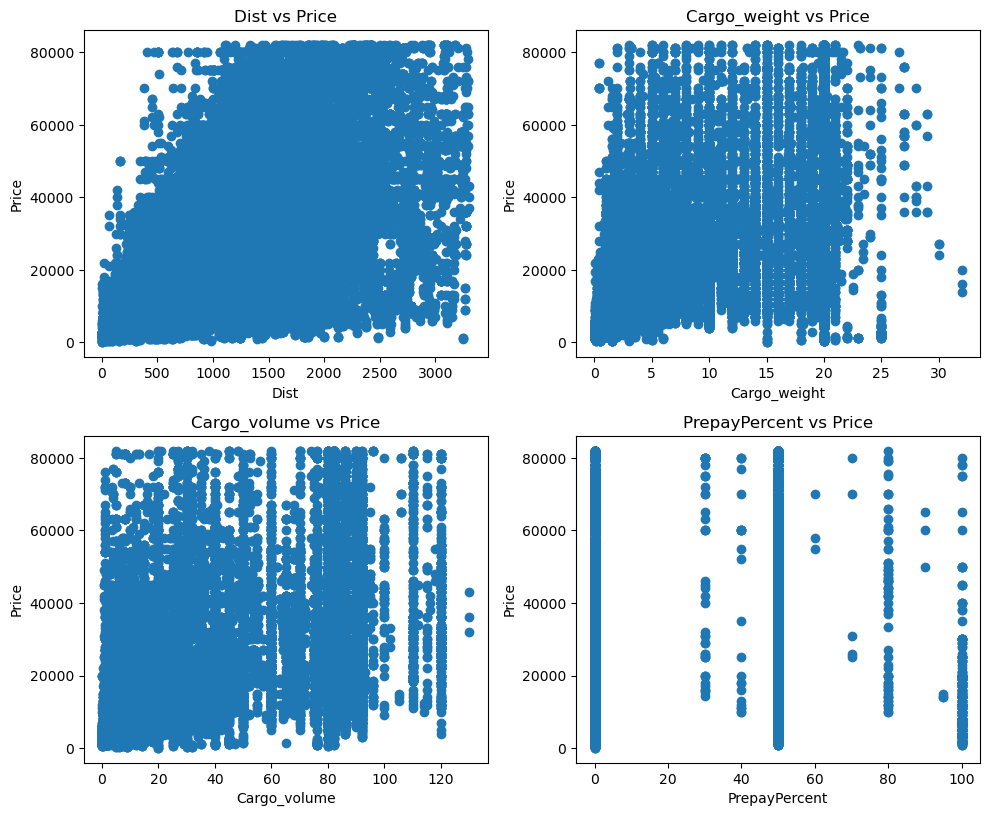

In [1503]:
plt.figure(figsize=(10,20))

scatter('Dist', 1)
scatter('Cargo_weight', 2)
scatter('Cargo_volume', 3)
scatter('PrepayPercent', 4)

plt.tight_layout()
# Расстояние перевозки имеет положительную корреляцию с ценой перевозки. Есть связь с весом груза и обьемом груза,
# но вес и обьем взаимозависимы.
# остальные признаки не существенны, точки расположены случайным образом 

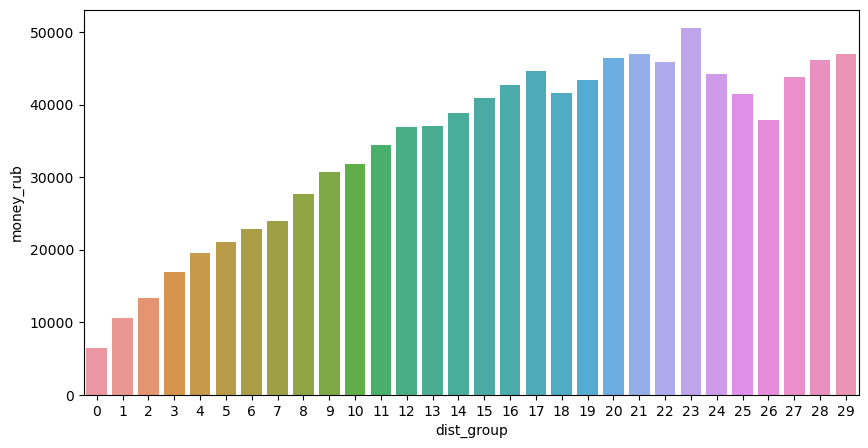

In [1504]:
data['dist_group'] = pd.cut(data['Dist'], bins=30, labels=range(0, 30))
df = data.groupby('dist_group').agg({'money_rub': 'mean'}).reset_index()
df = df.sort_values(by='money_rub', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x='dist_group', y='money_rub', data=df)
plt.show()
data.drop(['dist_group'], axis=1, inplace=True)
# C возрастанием расстояния перевозки возрастает и цена

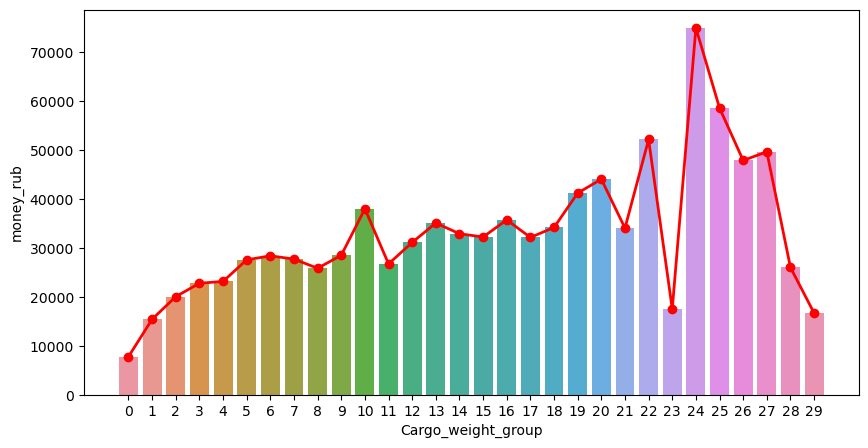

In [1505]:
bins = 30
data['Cargo_weight_group'] = pd.cut(data['Cargo_weight'], bins=bins, labels=range(bins))
df = data.groupby('Cargo_weight_group').agg({'money_rub': 'mean'}).reset_index()
df = df.sort_values(by='Cargo_weight_group', ascending=True)
plt.figure(figsize=(10,5))
sns.barplot(x='Cargo_weight_group', y='money_rub', data=df)
plt.plot(df.index, df['money_rub'], 'ro-', linewidth=2)
plt.xticks(range(bins), df.Cargo_weight_group)
plt.show()
data.drop(['Cargo_weight_group'], axis=1, inplace=True)

# По данному графику видно, что вес груза имеет положительную корреляцию с ценой перевозки

In [1506]:
data.corr()
# Как и предполагалось, расстояние перевозки и вес груза взаимосвязано с ценой, имеет умеренную корреляцию.
# Что еще можно отметить - расстояние перевозки влияет на процент предоплаты. Обьем груза тоже влияет на цену, 
# и он так же имеет корреляцию с весом груза.


Cargo_volume  Cargo_weight  ADR  Qu_Cars      Dist  \
Cargo_volume       1.000000      0.591304  NaN      NaN -0.081389   
Cargo_weight       0.591304      1.000000  NaN      NaN  0.032015   
ADR                     NaN           NaN  NaN      NaN       NaN   
Qu_Cars                 NaN           NaN  NaN      NaN       NaN   
Dist              -0.081389      0.032015  NaN      NaN  1.000000   
PalletCount             NaN           NaN  NaN      NaN       NaN   
PrepayPercent     -0.053555      0.071174  NaN      NaN  0.420459   
money_rub          0.363835      0.415570  NaN      NaN  0.572644   

               PalletCount  PrepayPercent  money_rub  
Cargo_volume           NaN      -0.053555   0.363835  
Cargo_weight           NaN       0.071174   0.415570  
ADR                    NaN            NaN        NaN  
Qu_Cars                NaN            NaN        NaN  
Dist                   NaN       0.420459   0.572644  
PalletCount            NaN            NaN        NaN  
PrepayPercent          NaN       1.000000   0.196137  
money_rub              NaN       0.196137   1.000000

In [1507]:
def categorical_visualization(cols):
    plt.figure(figsize=(50,20))
    plt.subplot(1,3,1)
    sns.countplot(x=cols,data=data,palette="Set2",order=data[cols].value_counts().index)
    plt.title(f"{cols} Distribution",pad=10,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)

    plt.subplot(1,3,2)
    sns.boxplot(x=cols,y="money_rub",data=data,palette="Set2")
    plt.title(f"{cols} vs Price",pad=20,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)
    
    plt.subplot(1,3,3)
    sns.barplot(x=cols, y="money_rub", data=data, palette="Set2")
    plt.title(f"{cols} vs Average Price",pad=20,fontweight="black",fontsize=18)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


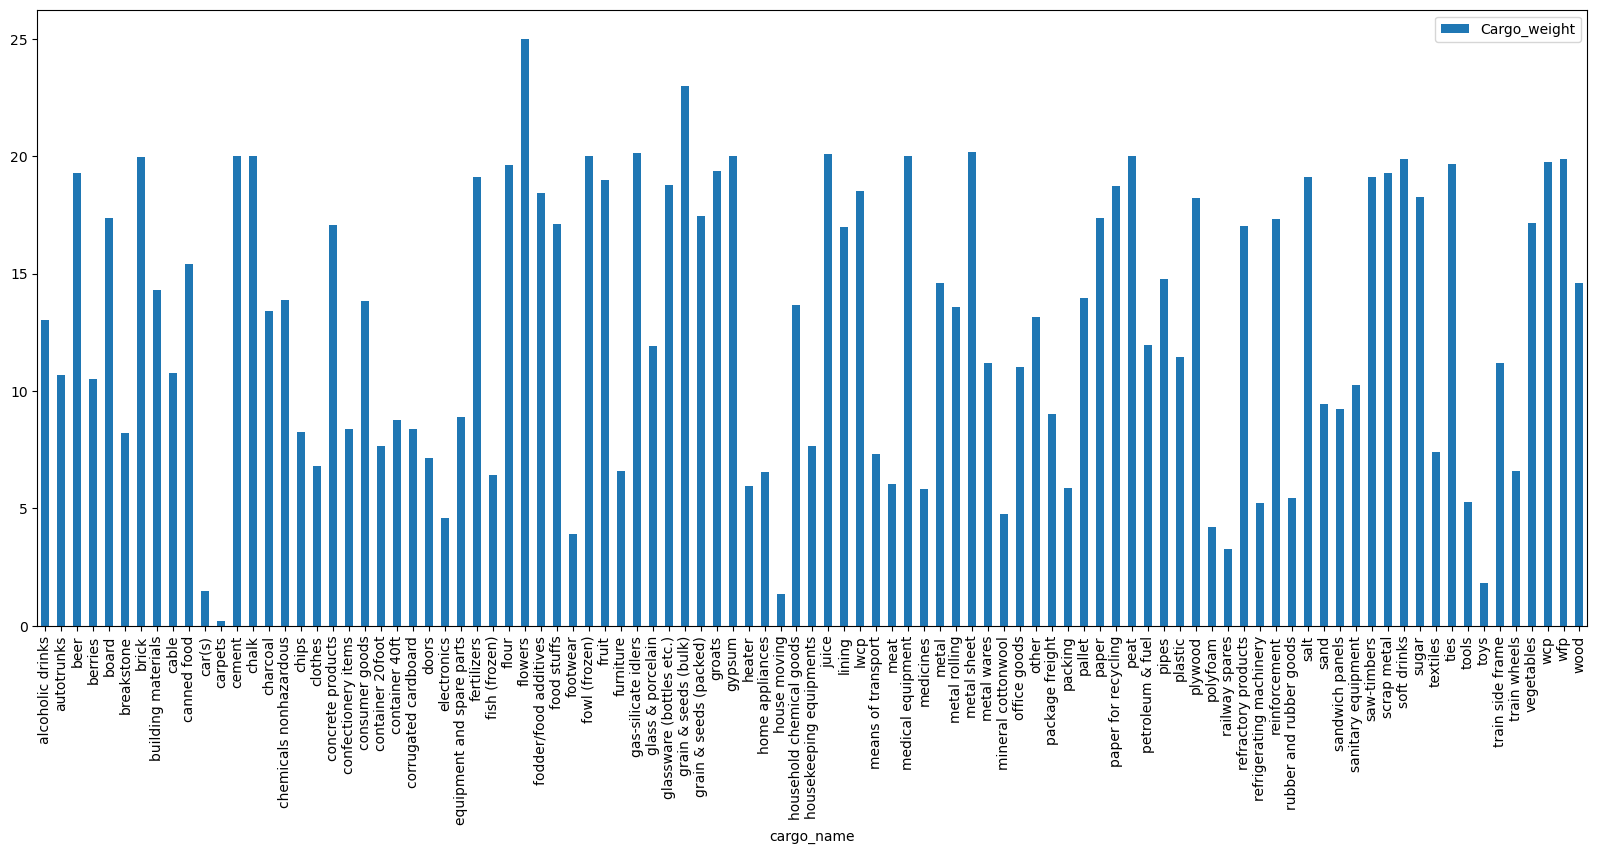

In [1508]:
pivot_table = data.pivot_table(index='cargo_name', values='Cargo_weight', aggfunc='mean')
pivot_table.plot(kind='bar', figsize=(20,8))
plt.show()

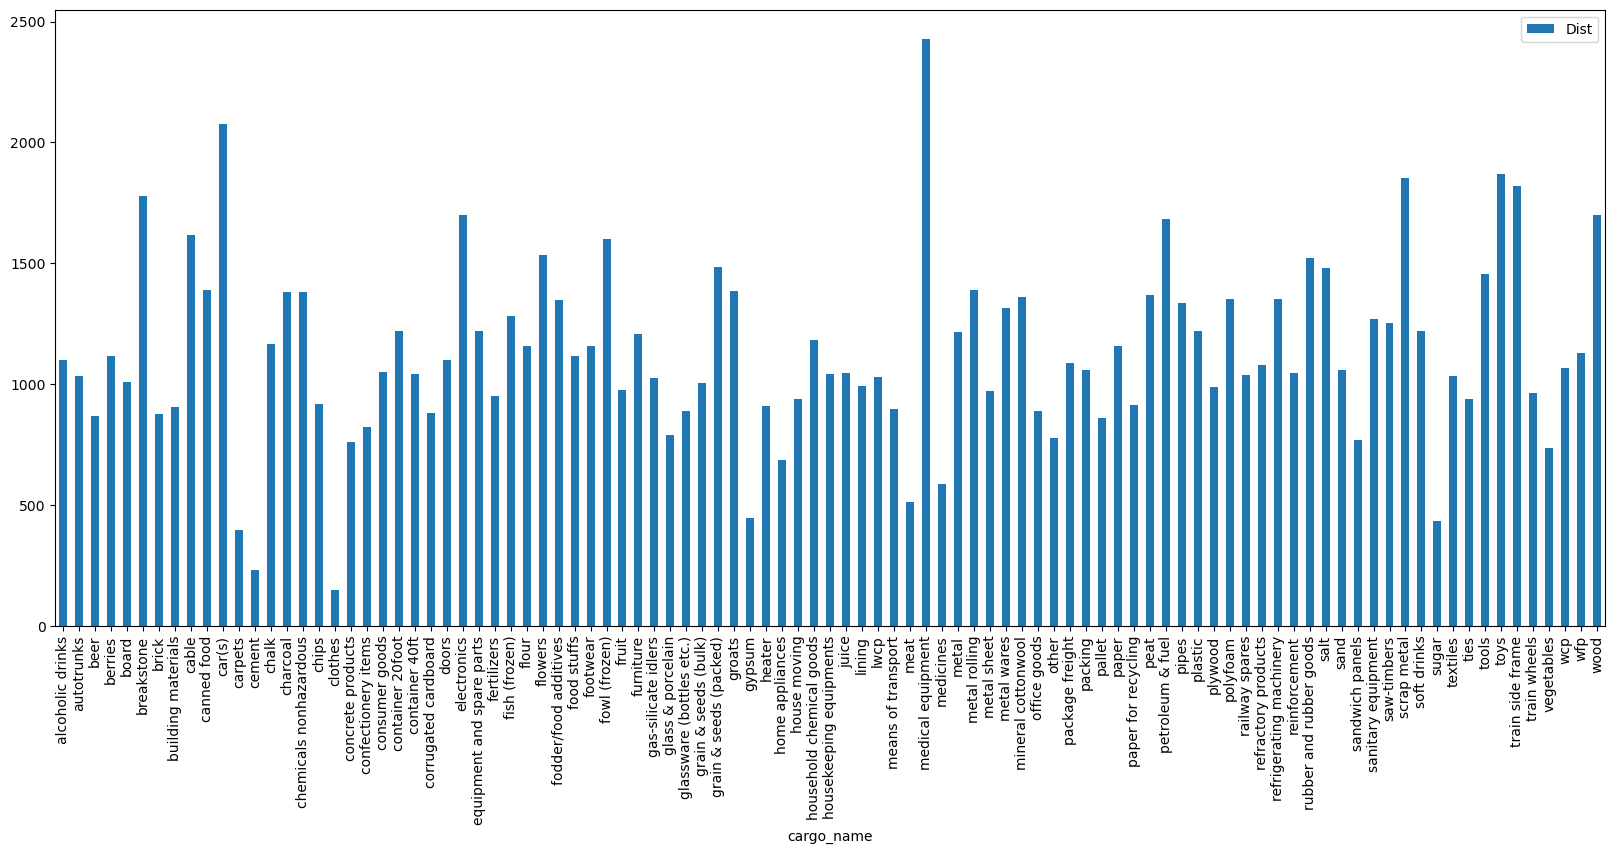

In [1509]:
pivot_table = data.pivot_table(index='cargo_name', values='Dist', aggfunc='mean')
pivot_table.plot(kind='bar', figsize=(20,8))
plt.show()

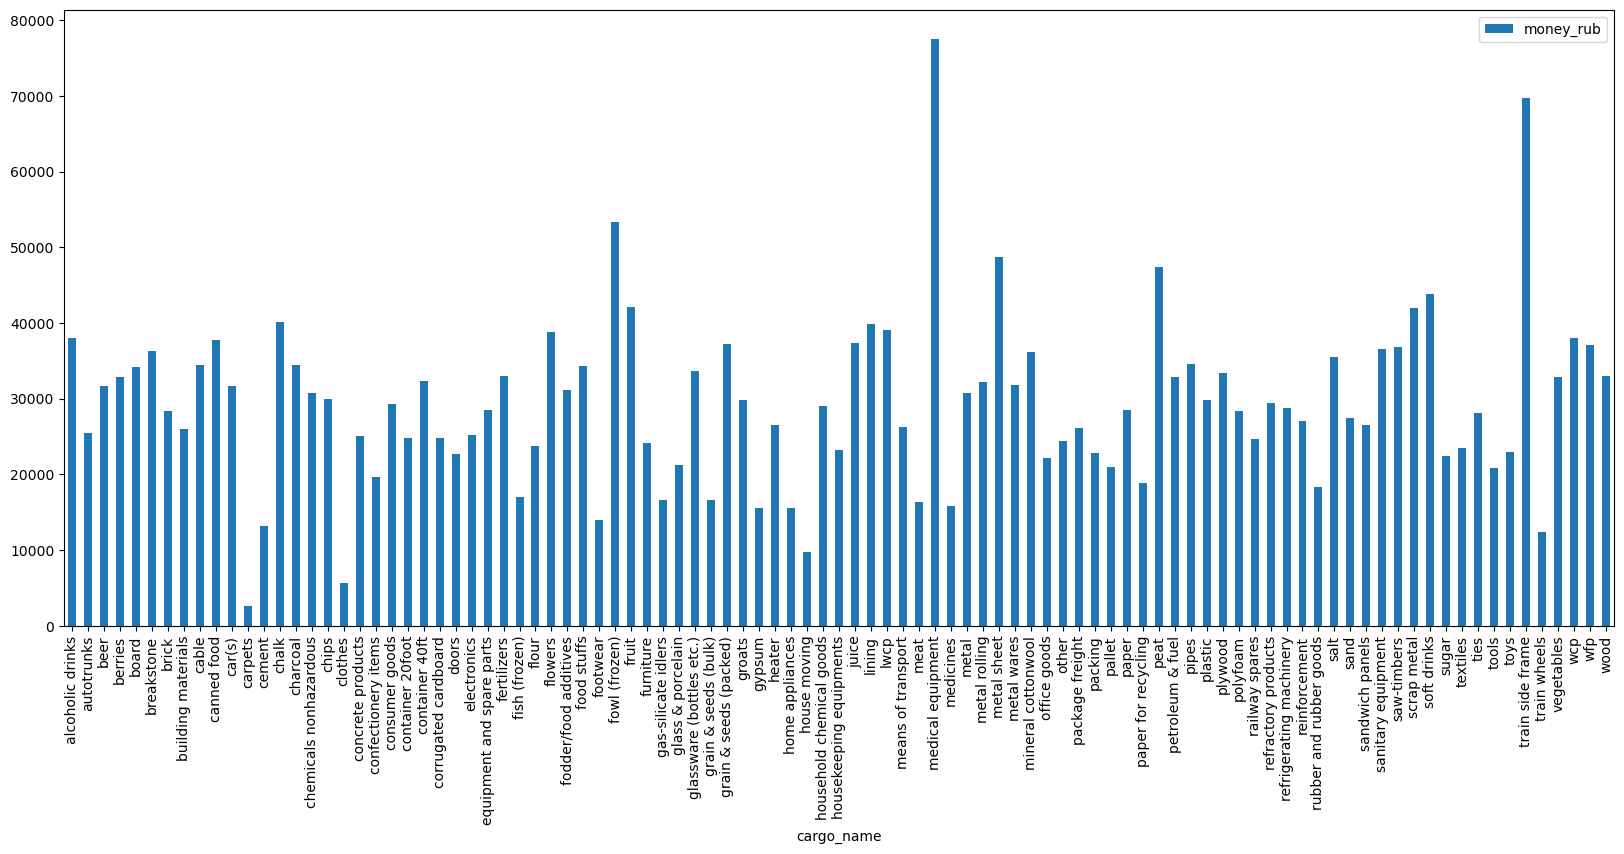

In [1510]:
pivot_table = data.pivot_table(index='cargo_name', values='money_rub', aggfunc='mean')
pivot_table.plot(kind='bar', figsize=(20,8))
plt.show()


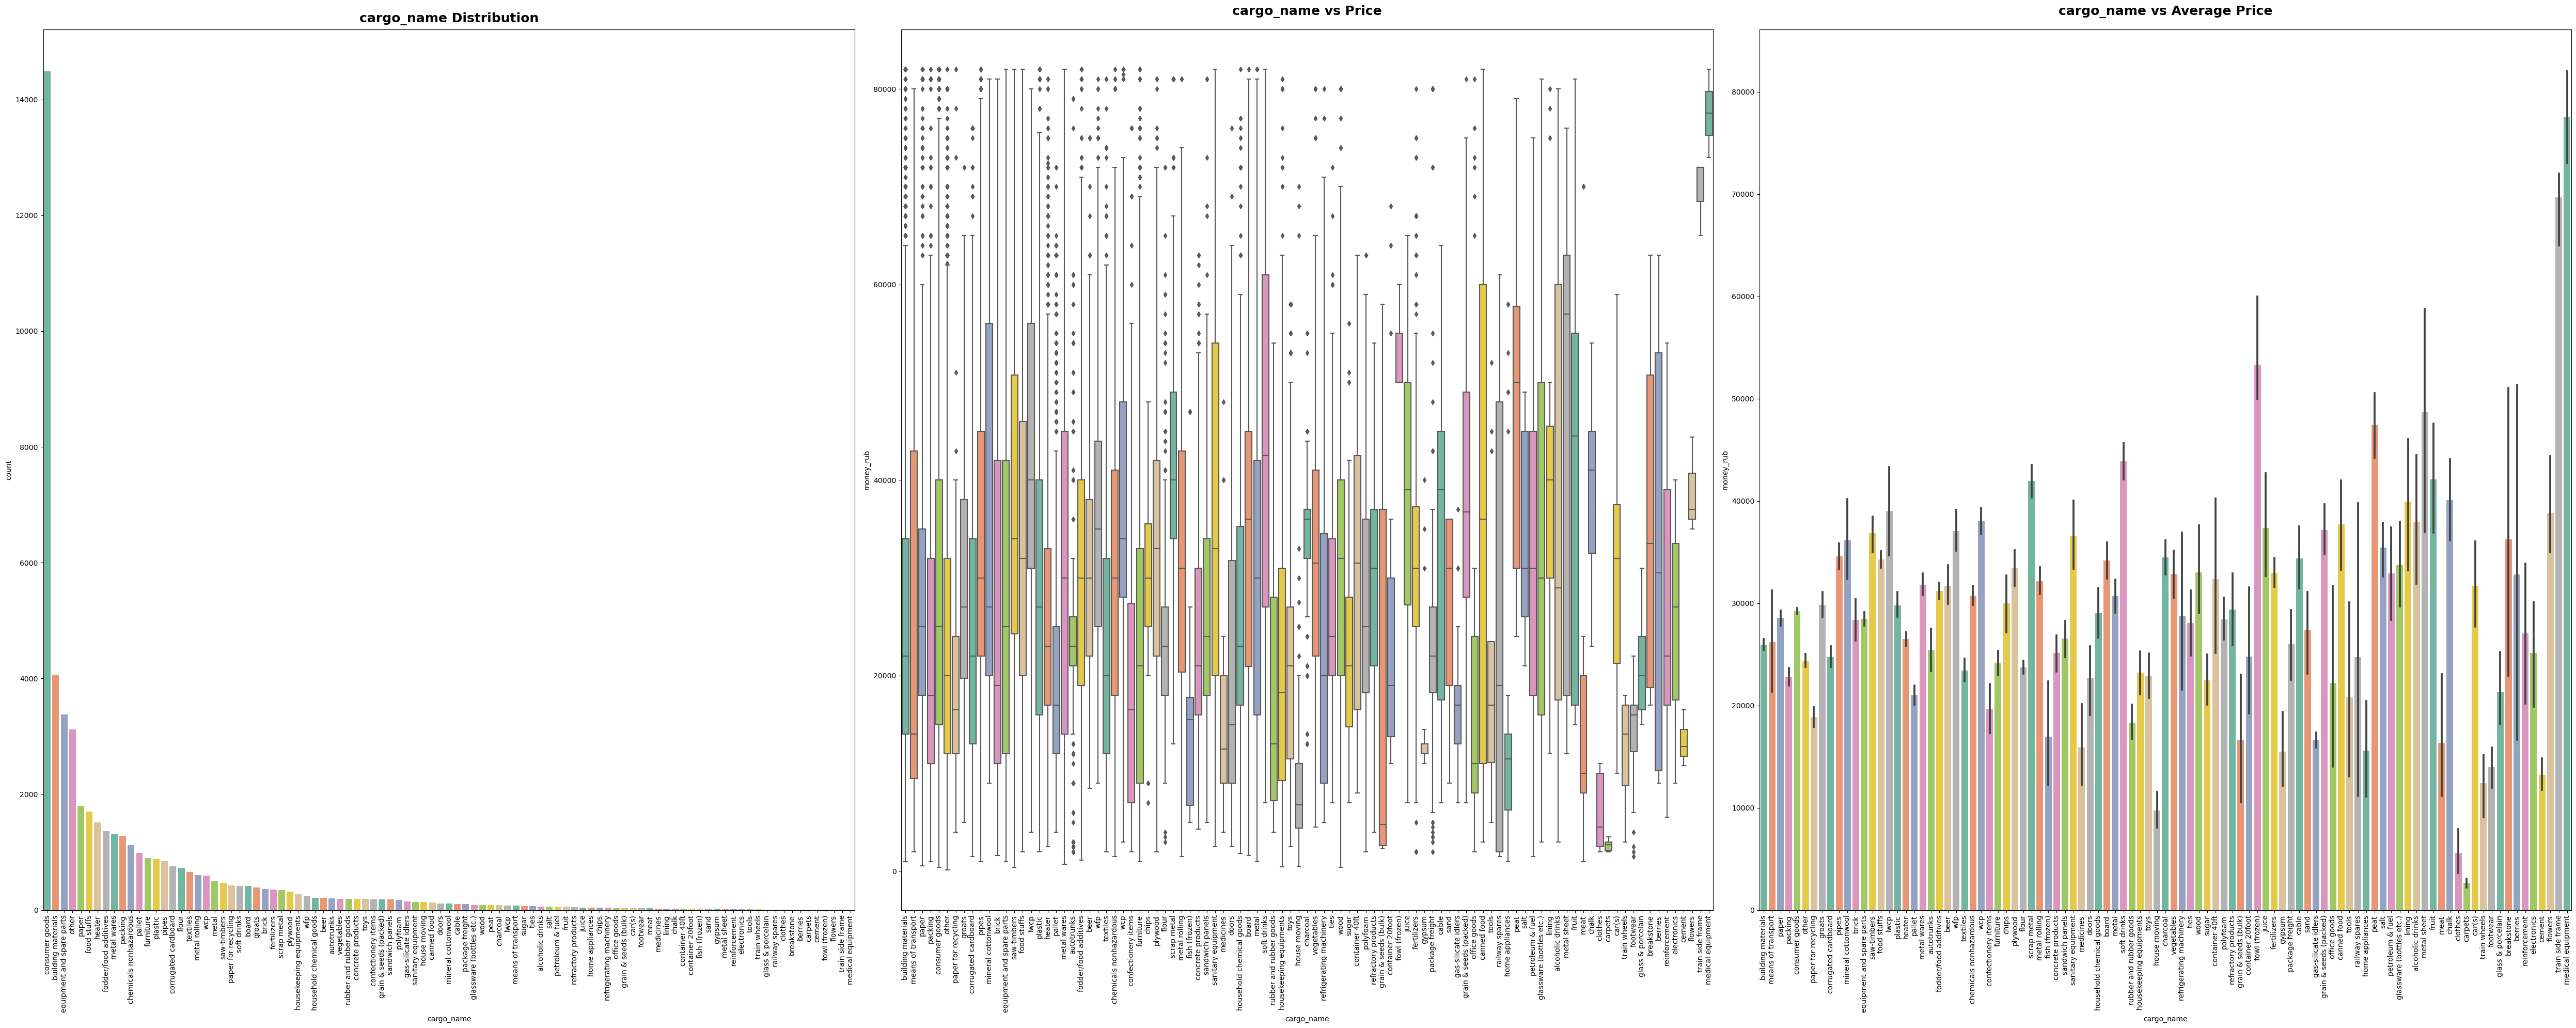

In [1511]:
categorical_visualization("cargo_name")
#Cудя по данным графикам, цена зависит от того, какой груз перевозится

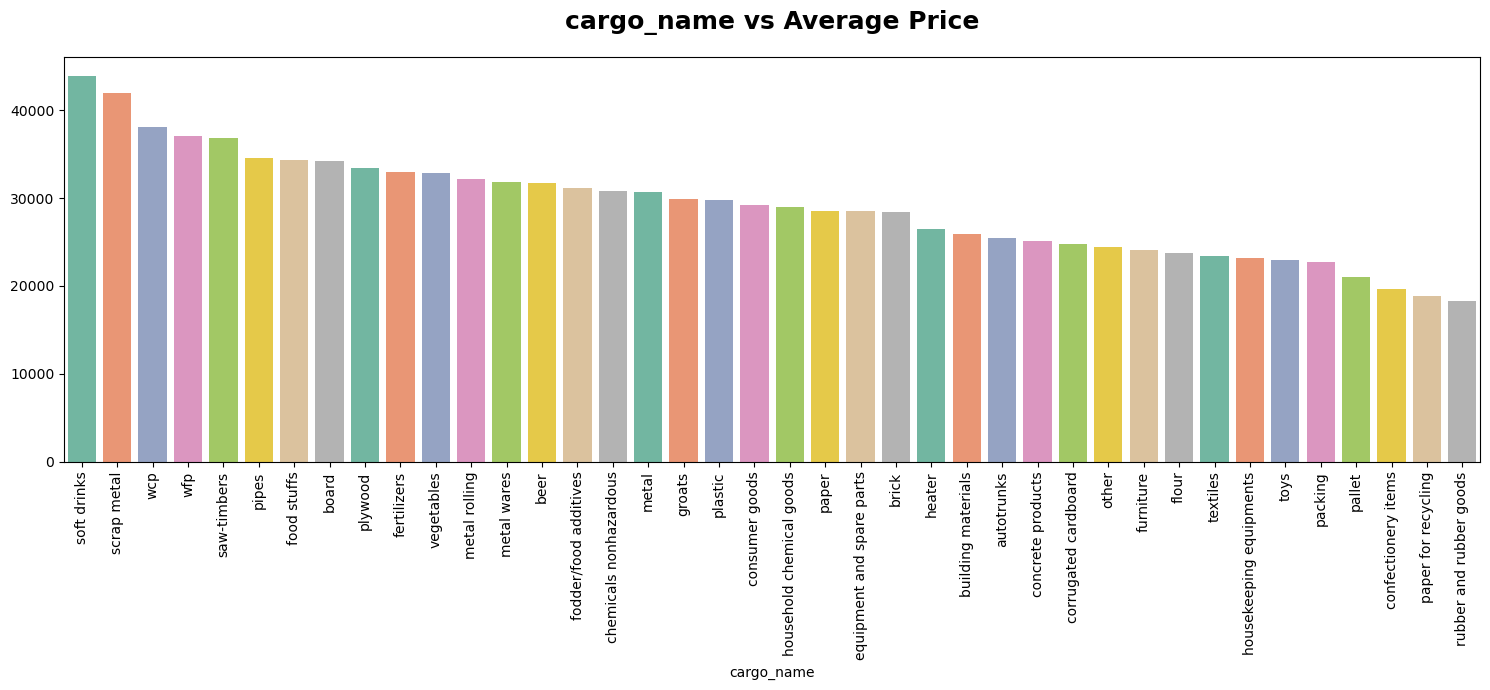

In [1512]:
n = 40
counts = data['cargo_name'].value_counts().head(n)
selected_values = counts.index.tolist()
filtered_df = data[data['cargo_name'].isin(selected_values)]

x = filtered_df.groupby('cargo_name')["money_rub"].mean().sort_values(ascending=False) 
plt.figure(figsize=(15,7))
sns.barplot(x=x.index, y=x.values, palette="Set2")
plt.title(f"cargo_name vs Average Price",pad=20,fontweight="black",fontsize=18)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
#какие из n наиболее встречающихся категорий груза имеют наиболее высокую стоимость для перевозки

In [1513]:
a = pd.cut(data.money_rub, bins=[0, 20000, 40000, 60000])
a

3                        NaN
4             (0.0, 20000.0]
5         (40000.0, 60000.0]
7         (20000.0, 40000.0]
8         (20000.0, 40000.0]
                 ...        
114451        (0.0, 20000.0]
114452        (0.0, 20000.0]
114453    (20000.0, 40000.0]
114454        (0.0, 20000.0]
114455        (0.0, 20000.0]
Name: money_rub, Length: 51357, dtype: category
Categories (3, interval[int64, right]): [(0, 20000] < (20000, 40000] < (40000, 60000]]

In [1514]:
data[['Cargo_volume', 'Cargo_weight']].head(10)
# Можно объединить обьем и вес груза в один признак - плотность. 
# Это позволит избежать проблемы, когда два признака сильно коррелируют между собой,
# что может привести к ошибкам модели.



Cargo_volume  Cargo_weight
3           80.0          20.0
4            5.9           0.7
5           82.0          20.0
7           16.0           3.2
8           82.0          20.0
15          50.0          21.0
18          82.0          20.0
19          82.0          20.0
22          85.0          20.0
24          40.0          12.2

In [1515]:
data['cargo_weight_volume'] = data['Cargo_weight'] * data['Cargo_volume']

In [1516]:
data = delete_outliers(data, 'cargo_weight_volume')
data.corr() # возможно коэффициент корреляции
# не учитывает возможные нелинейные зависимости между признаками и погрешности данных?

Cargo_volume  Cargo_weight  ADR  Qu_Cars      Dist  \
Cargo_volume             1.000000      0.591304  NaN      NaN -0.081389   
Cargo_weight             0.591304      1.000000  NaN      NaN  0.032015   
ADR                           NaN           NaN  NaN      NaN       NaN   
Qu_Cars                       NaN           NaN  NaN      NaN       NaN   
Dist                    -0.081389      0.032015  NaN      NaN  1.000000   
PalletCount                   NaN           NaN  NaN      NaN       NaN   
PrepayPercent           -0.053555      0.071174  NaN      NaN  0.420459   
money_rub                0.363835      0.415570  NaN      NaN  0.572644   
cargo_weight_volume      0.810476      0.882647  NaN      NaN -0.014891   

                     PalletCount  PrepayPercent  money_rub  \
Cargo_volume                 NaN      -0.053555   0.363835   
Cargo_weight                 NaN       0.071174   0.415570   
ADR                          NaN            NaN        NaN   
Qu_Cars                      NaN            NaN        NaN   
Dist                         NaN       0.420459   0.572644   
PalletCount                  NaN            NaN        NaN   
PrepayPercent                NaN       1.000000   0.196137   
money_rub                    NaN       0.196137   1.000000   
cargo_weight_volume          NaN      -0.003899   0.377392   

                     cargo_weight_volume  
Cargo_volume                    0.810476  
Cargo_weight                    0.882647  
ADR                                  NaN  
Qu_Cars                              NaN  
Dist                           -0.014891  
PalletCount                          NaN  
PrepayPercent                  -0.003899  
money_rub                       0.377392  
cargo_weight_volume             1.000000

In [1517]:
# Больше рассматривать категориальные данные не будем, так как место отгрузки и загрузки не имеет значения,
# когда есть данные о расстоянии.
# В результате анализа можно сделать вывод о том, что значимыми признаками, влияющими на цену перевозки, являются:
# название груза, расстояние перевозки и плотность груза.

In [1518]:
#чтобы проверить, прав ли бизнес насчет того, что цена всегда должна расти при увеличении массы и дистанции
#перевозки, при прочих равных условиях, обучим модели только с признаками расстояния и массы, и не только с ними,
#и проверим метрики каких моделей будут лучше

In [1519]:
z = round(data.groupby(["cargo_name"])["money_rub"].agg(["mean"]),2).T

In [1520]:
data = data.merge(z.T,how="left",on="cargo_name")

In [1521]:
data

city_load country_load      city_unload country_unload  \
0            казань       россия   индустриальный         россия   
1             можга       россия     екатеринбург         россия   
2         кондопога       россия  нижний новгород         россия   
3            самара       россия        краснодар         россия   
4           елабуга       россия          воронеж         россия   
...             ...          ...              ...            ...   
51352  наро-фоминск       россия          воронеж         россия   
51353        тамбов       россия   ростов-на-дону         россия   
51354     минусинск       россия           курган         россия   
51355           уфа       россия       бугуруслан         россия   
51356        казань       россия         владимир         россия   

       Cargo_volume  Cargo_weight  ADR  Qu_Cars  Dist  PalletCount  \
0              80.0          20.0    0        1  1363            0   
1               5.9           0.7    0        1   775            0   
2              82.0          20.0    0        1  1481            0   
3              16.0           3.2    0        1  1631            0   
4              82.0          20.0    0        1  1293            0   
...             ...           ...  ...      ...   ...          ...   
51352          20.0           3.0    0        1   554            0   
51353          76.0          25.0    0        1   754            0   
51354          20.0          20.0    0        1  2266            0   
51355          82.0          20.0    0        1   328            0   
51356          82.0           5.0    0        1   640            0   

               cargo_name  PrepayPercent  money_rub        Date  \
0      building materials             50    74000.0  2023-05-17   
1      means of transport              0     9000.0  2023-03-15   
2                   paper             50    48000.0  2023-03-31   
3                 packing             50    27000.0  2023-02-02   
4          consumer goods             50    39000.0  2023-04-07   
...                   ...            ...        ...         ...   
51352           furniture              0     8000.0  2023-03-23   
51353      consumer goods             50     1800.0  2023-03-03   
51354         scrap metal             50    38000.0  2023-05-16   
51355  building materials              0    10000.0  2023-05-11   
51356              heater              0    19000.0  2023-03-31   

       cargo_weight_volume      mean  
0                  1600.00  25966.24  
1                     4.13  26218.67  
2                  1640.00  28556.75  
3                    51.20  22761.08  
4                  1640.00  29245.06  
...                    ...       ...  
51352                60.00  24141.39  
51353              1900.00  29245.06  
51354               400.00  41941.26  
51355              1640.00  25966.24  
51356               410.00  26497.94  

[51357 rows x 16 columns]

In [1522]:
cargo_bin=['Low','Medium','High']
data['cargo_range'] = pd.qcut(data['mean'], q = 3, labels=cargo_bin)
data.head()

city_load country_load      city_unload country_unload  Cargo_volume  \
0     казань       россия   индустриальный         россия          80.0   
1      можга       россия     екатеринбург         россия           5.9   
2  кондопога       россия  нижний новгород         россия          82.0   
3     самара       россия        краснодар         россия          16.0   
4    елабуга       россия          воронеж         россия          82.0   

   Cargo_weight  ADR  Qu_Cars  Dist  PalletCount          cargo_name  \
0          20.0    0        1  1363            0  building materials   
1           0.7    0        1   775            0  means of transport   
2          20.0    0        1  1481            0               paper   
3           3.2    0        1  1631            0             packing   
4          20.0    0        1  1293            0      consumer goods   

   PrepayPercent  money_rub        Date  cargo_weight_volume      mean  \
0             50    74000.0  2023-05-17              1600.00  25966.24   
1              0     9000.0  2023-03-15                 4.13  26218.67   
2             50    48000.0  2023-03-31              1640.00  28556.75   
3             50    27000.0  2023-02-02                51.20  22761.08   
4             50    39000.0  2023-04-07              1640.00  29245.06   

  cargo_range  
0         Low  
1         Low  
2      Medium  
3         Low  
4      Medium

In [1523]:
print(data[data['cargo_range'] == 'Low']['mean'].min())
print(data[data['cargo_range'] == 'Low']['mean'].max())
print(data[data['cargo_range'] == 'Medium']['mean'].min())
print(data[data['cargo_range'] == 'Medium']['mean'].max())
print(data[data['cargo_range'] == 'High']['mean'].min())
print(data[data['cargo_range'] == 'High']['mean'].max())
print(data['cargo_range'].value_counts()['Low'])
print(data['cargo_range'].value_counts()['Medium'])
print(data['cargo_range'].value_counts()['High'])


2650.0
28375.9
28398.85
29245.06
29392.16
77500.0
17322
20097
13938


In [1524]:
#вариант только с Cargo_weight' и 'Dist'

In [1525]:
new_data = data[['Cargo_weight', 'Dist', 'money_rub']]
new_data                  

Cargo_weight  Dist  money_rub
0              20.0  1363    74000.0
1               0.7   775     9000.0
2              20.0  1481    48000.0
3               3.2  1631    27000.0
4              20.0  1293    39000.0
...             ...   ...        ...
51352           3.0   554     8000.0
51353          25.0   754     1800.0
51354          20.0  2266    38000.0
51355          20.0   328    10000.0
51356           5.0   640    19000.0

[51357 rows x 3 columns]

In [1526]:
num_cols = ['Cargo_weight', 'Dist']
new_data[num_cols] = scaler.fit_transform(new_data[num_cols])
new_data

/var/folders/5_/f8txjnjs6n7fh09t4qnqq2d80000gn/T/ipykernel_93290/2226965291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[num_cols] = scaler.fit_transform(new_data[num_cols])


Cargo_weight      Dist  money_rub
0          0.859906  0.421484    74000.0
1         -1.652099 -0.466104     9000.0
2          0.859906  0.599606    48000.0
3         -1.326710  0.826031    27000.0
4          0.859906  0.315819    39000.0
...             ...       ...        ...
51352     -1.352741 -0.799704     8000.0
51353      1.510684 -0.497803     1800.0
51354      0.859906  1.784566    38000.0
51355      0.859906 -1.140852    10000.0
51356     -1.092430 -0.669887    19000.0

[51357 rows x 3 columns]

In [1527]:
x = new_data.drop(columns=["money_rub"])
y = new_data["money_rub"]

In [1528]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [1529]:
training_score = []
testing_score = []

In [1530]:
def model_prediction(model):
    model.fit(x_train,y_train)
    x_train_pred = model.predict(x_train)
    x_test_pred = model.predict(x_test)
    a = r2_score(y_train,x_train_pred)*100
    b = r2_score(y_test,x_test_pred)*100
    training_score.append(a)
    testing_score.append(b)
    
    print(f"r2_Score of {model} model on Training Data is:",a)
    print(f"r2_Score of {model} model on Testing Data is:",b)

In [1531]:
model_prediction(LinearRegression())

r2_Score of LinearRegression() model on Training Data is: 48.45003424593295
r2_Score of LinearRegression() model on Testing Data is: 49.148301175937334


In [1532]:
model_prediction(DecisionTreeRegressor())

r2_Score of DecisionTreeRegressor() model on Training Data is: 86.68854869614697
r2_Score of DecisionTreeRegressor() model on Testing Data is: 81.9041802146353


In [1533]:
model_prediction(RandomForestRegressor())

r2_Score of RandomForestRegressor() model on Training Data is: 86.3926159650567
r2_Score of RandomForestRegressor() model on Testing Data is: 81.44322770014418


In [1534]:
model_prediction(AdaBoostRegressor())

r2_Score of AdaBoostRegressor() model on Training Data is: 51.18598944916095
r2_Score of AdaBoostRegressor() model on Testing Data is: 51.63513795244287


In [1535]:
model_prediction(GradientBoostingRegressor())

r2_Score of GradientBoostingRegressor() model on Training Data is: 59.92082424245646
r2_Score of GradientBoostingRegressor() model on Testing Data is: 59.792238747557505


In [1536]:
model_prediction(XGBRegressor())

r2_Score of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) model on Training Data is: 73.78484241434127
r2_Score of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
      

In [1537]:
#2 вариант с остальными значимыми признаками

In [1538]:
new_data = data[['cargo_weight_volume', 'cargo_range', 'Dist', 'money_rub']]
new_data                

cargo_weight_volume cargo_range  Dist  money_rub
0                  1600.00         Low  1363    74000.0
1                     4.13         Low   775     9000.0
2                  1640.00      Medium  1481    48000.0
3                    51.20         Low  1631    27000.0
4                  1640.00      Medium  1293    39000.0
...                    ...         ...   ...        ...
51352                60.00         Low   554     8000.0
51353              1900.00      Medium   754     1800.0
51354               400.00        High  2266    38000.0
51355              1640.00         Low   328    10000.0
51356               410.00         Low   640    19000.0

[51357 rows x 4 columns]

In [1539]:
new_data = pd.get_dummies(columns=["cargo_range"], data=new_data)


In [1547]:
new_data

cargo_weight_volume      Dist  money_rub  cargo_range_Low  \
0                 0.957110  0.421484    74000.0                1   
1                -1.385282 -0.466104     9000.0                1   
2                 1.015821  0.599606    48000.0                0   
3                -1.316193  0.826031    27000.0                1   
4                 1.015821  0.315819    39000.0                0   
...                    ...       ...        ...              ...   
51352            -1.303277 -0.799704     8000.0                1   
51353             1.397445 -0.497803     1800.0                0   
51354            -0.804230  1.784566    38000.0                0   
51355             1.015821 -1.140852    10000.0                1   
51356            -0.789552 -0.669887    19000.0                1   

       cargo_range_Medium  cargo_range_High  
0                       0                 0  
1                       0                 0  
2                       1                 0  
3                       0                 0  
4                       1                 0  
...                   ...               ...  
51352                   0                 0  
51353                   1                 0  
51354                   0                 1  
51355                   0                 0  
51356                   0                 0  

[51357 rows x 6 columns]

In [1540]:
num_cols = ['cargo_weight_volume', 'Dist']
new_data[num_cols] = scaler.fit_transform(new_data[num_cols])

In [1541]:
x = new_data.drop(columns=["money_rub"])
y = new_data["money_rub"]

In [1542]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [1543]:
training_score = []
testing_score = []

In [1544]:
model_prediction(DecisionTreeRegressor())

r2_Score of DecisionTreeRegressor() model on Training Data is: 95.20345319263993
r2_Score of DecisionTreeRegressor() model on Testing Data is: 90.05142990097859


In [1545]:
model_prediction(RandomForestRegressor())

r2_Score of RandomForestRegressor() model on Training Data is: 94.79952078507824
r2_Score of RandomForestRegressor() model on Testing Data is: 89.85357744360877


In [1546]:
#предсказания с признаками 'cargo_weight_volume', 'cargo_range', 'Dist' оказались лучше, бизнес не прав